In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18
from astropy.cosmology import FLRW, w0waCDM, LambdaCDM, FlatLambdaCDM
from astropy import constants

from bed.grid import Grid, TopHat, CosineBump, Gaussian
from bed.design import ExperimentDesigner

import pandas as pd
from scipy.integrate import quad, cumulative_trapezoid
import time
import torch

import pyro
from pyro import poutine
from pyro import distributions as dist

device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(f'Using device: {device}.')

desi_data = pd.read_csv('/home/ashandonay/bed/desi_data.csv')

Using device: cuda:0.


In [189]:
class bed_cosmology:

    def __init__(self, cosmo_params, priors, obs_labels, z_eff, sigma_D_H, sigma_D_M=None, device=device):
        self.cosmo_params = set(cosmo_params)
        self.priors = priors
        self.obs_labels = obs_labels
        self.z_eff = z_eff
        self.sigma_D_H = sigma_D_H
        self.sigma_D_M = sigma_D_M
        self.r_drag = 149.77
        self.H0 = Planck18.H0.value
        self.coeff = constants.c.to('km/s').value/(self.H0*self.r_drag)
        self.device = device
    
    def D_H_func(self, z, Om, w0=None, wa=None):
        if self.cosmo_params == {'Om'}:
            return self.coeff / torch.sqrt(Om * (1+z)**3 + (1-Om))

        elif self.cosmo_params == {'Om', 'w0'}:
            return self.coeff / torch.sqrt(Om * (1+z)**3 + (1-Om) * (1+z)**(3*(1+w0)))

        elif self.cosmo_params == {'Om', 'w0', 'wa'}:
            return self.coeff / torch.sqrt(Om * (1+z)**3 + (1-Om) * (1+z)**(3*(1+(w0+wa*(z/(1+z))))))
            
        else:
            raise ValueError(f"Unsupported cosmology model: {self.cosmo.name}")

    def D_M_func(self, z, Om, w0=None, wa=None):
        if self.cosmo_params == {'Om'}:
            result = self.coeff * trapezoid(
                (1 / torch.sqrt(Om.unsqueeze(-1) * (1 + z)**3 + (1 - Om.unsqueeze(-1)))).cpu(), 
                z.cpu(), 
                axis=-1)
            return torch.tensor(result).to(self.device)

        elif self.cosmo_params == {'Om', 'w0'}:
            result = self.coeff * trapezoid(
                (1 / torch.sqrt(Om.unsqueeze(-1) * (1 + z)**3 + (1 - Om.unsqueeze(-1)) * (1 + z)**(3 * (1 + w0.unsqueeze(-1))))).cpu(), 
                z.cpu(), 
                axis=-1)
            return torch.tensor(result).to(self.device)

        elif self.cosmo_params == {'Om', 'w0', 'wa'}:
            result = self.coeff * trapezoid(
                (1 / torch.sqrt(Om.unsqueeze(-1) * (1 + z)**3 + (1 - Om.unsqueeze(-1)) * (1 + z)**(3 * (1 + (w0.unsqueeze(-1) + wa.unsqueeze(-1) * (z / (1 + z))))))).cpu(), 
                z.cpu(), 
                axis=-1)
            return torch.tensor(result).to(self.device)
            
        else:
            raise ValueError(f"Unsupported cosmology model: {self.cosmo.name}")
    
    def pyro_model(self, tracers_ratio):
        with pyro.plate_stack("plate", tracers_ratio.shape[:-1]):
            parameters = {}
            for i, (k, v) in enumerate(self.priors.items()):
                if isinstance(v, dist.Distribution):
                    parameters[k] = pyro.sample(k, v).unsqueeze(-1)
                else:
                    parameters[k] = v

            z = self.z_eff.reshape((len(self.cosmo_params)-1)*[1] + [-1])
            means = self.D_H_func(z, **parameters)
            sigmas = self.sigma_D_H * torch.sqrt(tracers_ratio)

            if self.sigma_D_M is not None:
                z_array = self.z_eff.unsqueeze(-1) * torch.linspace(0, 1, 100, device=self.device).view(1, -1)
                z = z_array.expand((len(self.cosmo_params)-1)*[1] + [-1, -1])
                D_M_mean = self.D_M_func(z, **parameters)
                D_M_sigmas = self.sigma_D_M * torch.sqrt(tracers_ratio)
                means = torch.cat((means, D_M_mean), dim=-1)
                sigmas = torch.cat((sigmas, D_M_sigmas), dim=-1)

            #for i,o in enumerate(self.obs_labels):
            #    pyro.sample(o, dist.Normal(means[..., i].unsqueeze(-1), sigmas[..., i].unsqueeze(-1)).to_event(1))
            covariance_matrix = torch.diag_embed(sigmas ** 2)
            return pyro.sample("y", dist.MultivariateNormal(means, covariance_matrix))

    def unnorm_lfunc(self, params, features, designs):
        parameters = { }
        for key in params.names:
            parameters[key] = torch.tensor(getattr(params, key), device=self.device)
        likelihood = 1
        for i in range(len(self.z_eff)):
            z = self.z_eff[i].reshape((len(self.cosmo_params)-1)*[1] + [-1])
            D_H_mean = self.D_H_func(z, **parameters)
            D_H_diff = getattr(features, features.names[i]) - D_H_mean.cpu().numpy()
            D_H_sigma = (self.sigma_D_H.cpu().numpy()[i] * np.sqrt(getattr(designs, design.names[i])))
            likelihood = np.exp(-0.5 * (D_H_diff / D_H_sigma) ** 2) * likelihood
            
            if self.sigma_D_M is not None:
                z_array = self.z_eff[i].unsqueeze(-1) * torch.linspace(0, 1, 100, device=self.device).view(1, -1)
                z = z_array.expand((len(self.cosmo_params)-1)*[1] + [-1, -1])
                D_M_mean = self.D_M_func(z, **parameters)
                D_M_diff = getattr(features, features.names[i+len(self.z_eff)]) - D_M_mean.cpu().numpy()
                D_M_sigma = (self.sigma_D_M.cpu().numpy()[i] * np.sqrt(getattr(designs, design.names[i])))
                likelihood = np.exp(-0.5 * (D_M_diff / D_M_sigma) ** 2) * likelihood

        return likelihood

In [277]:
train_args = {
        "seed": 1,
        "cosmology": "Om", # Om, w, w0wa
        "tracers": ["LRG1", "LRG2", "ELG2"],
        "include_D_M": False,
        "flow_type": 'NAF',
        "design_precision": 2,
        "N_tot": 1000,
        "n_transforms": 10,
        "steps": 15000,
        "lr": 1e-2,
        "gamma": 0.8,
        "n_particles": 51,
        "eval_particles": 1000,
        "train_verbose": False, 
        "condition_design": True,
        "device": device
        }   

In [278]:
desi_data = pd.read_csv('/home/ashandonay/bed/desi_data.csv')
sigma_D_H = []
z_eff = []
true_n_vals = []
for t in train_args["tracers"]:
    D_H_std = desi_data.loc[(desi_data['tracer'] == t) & (desi_data['quantity'] == 'DH_over_rs'), "std"].values[0]
    z = desi_data.loc[desi_data['tracer'] == t, "z"].values[0]
    sigma_D_H.append(D_H_std * 1.0)
    z_eff.append(z)
    true_n_vals.append(desi_data.loc[desi_data['tracer'] == t, "num"].values[0])

sigma_D_H = torch.tensor(sigma_D_H, device=train_args["device"])
z_eff = torch.tensor(z_eff, device=train_args["device"])
true_n_vals = torch.tensor(true_n_vals, device=train_args["device"])

base = 10.0
scope = 0.1
ratio = true_n_vals/true_n_vals.sum()
design_step = np.power(base, -train_args["design_precision"])

design_dict = {}
for i in range(len(train_args["tracers"])):
    design_dict['N_' + train_args["tracers"][i].split()[0]] = np.arange(np.round(ratio[i].cpu().numpy() - scope, train_args["design_precision"]), 
        np.round(ratio[i].cpu().numpy() + scope, train_args["design_precision"]), design_step)
grid_designs = Grid(**design_dict, constraint=lambda **kwargs: np.abs(sum(kwargs.values()) - 1.0) < np.power(base, -(train_args["design_precision"] + 1)))
del design_dict
print("Grid designs shape:", grid_designs.shape)

Grid designs shape: (300, 1, 1)


In [203]:
designs = torch.tensor(getattr(grid_designs, grid_designs.names[0]).squeeze(), device=device).unsqueeze(1)
for n in grid_designs.names[1:]:
    designs = torch.cat((designs, torch.tensor(getattr(grid_designs, n).squeeze(), device=device).unsqueeze(1)), dim=1)

In [5]:
desi_data = pd.read_csv('/home/ashandonay/bed/desi_data.csv')

tracers = ["LRG2", "Lya QSO"]
#tracers = ["LRG2", "ELG2", "Lya QSO"]

include_D_M = False
cosmo_type = "Om"
design_step = 50

if len(tracers) == 2:
    designs = Grid(N_lrg=np.arange(design_step, 1000 + design_step, design_step), N_lya=np.arange(design_step, 1000 + design_step, design_step), constraint=lambda N_lrg, N_lya: N_lrg + N_lya == 1000)
elif len(tracers) == 3:
    designs = Grid(N_lrg=np.arange(design_step, 1000 + design_step, design_step), N_lya=np.arange(design_step, 1000 + design_step, design_step), N_elg=np.arange(design_step, 1000 + design_step, design_step), constraint = lambda N_lrg, N_lya, N_elg: N_lrg + N_lya + N_elg == 1000)

In [178]:
desi_data = pd.read_csv('/home/ashandonay/bed/desi_data.csv')
tracers = ["LRG2", "Lya QSO"]
sigma_D_H = []
z_eff = []
true_n_vals = []
for t in tracers:
    D_H_std = desi_data.loc[(desi_data['tracer'] == t) & (desi_data['quantity'] == 'DH_over_rs'), "std"].values[0]
    z = desi_data.loc[desi_data['tracer'] == t, "z"].values[0]
    sigma_D_H.append(D_H_std * 1.0)
    z_eff.append(z)
    true_n_vals.append(desi_data.loc[desi_data['tracer'] == t, "num"].values[0])

sigma_D_H = torch.tensor(sigma_D_H, device=device)
z_eff = torch.tensor(z_eff, device=device)
true_n_vals = torch.tensor(true_n_vals, device=device)

decimal = 2
base = 5.0
ratio = true_n_vals/true_n_vals.sum()
design_step = np.power(base, -decimal)
design_dict = {}
for i in range(len(tracers)):
    design_dict['N_' + tracers[i].split()[0]] = np.arange(np.round(ratio[i].cpu().numpy() - 0.2, decimal), np.round(ratio[i].cpu().numpy() + 0.2, decimal), design_step)
designs = Grid(**design_dict, constraint=lambda **kwargs: np.abs(sum(kwargs.values()) - 1.0) < np.power(base, -(decimal + 1)))

In [198]:
desi_data = pd.read_csv('/home/ashandonay/bed/desi_data.csv')

include_D_M = False
cosmo_type = "Om"
tracers = ["LRG2", "Lya QSO"]
sigma_D_H = []
z_eff = []
true_n_vals = []
for t in tracers:
    D_H_std = desi_data.loc[(desi_data['tracer'] == t) & (desi_data['quantity'] == 'DH_over_rs'), "std"].values[0]
    z = desi_data.loc[desi_data['tracer'] == t, "z"].values[0]
    sigma_D_H.append(D_H_std * 1.0)
    z_eff.append(z)
    true_n_vals.append(desi_data.loc[desi_data['tracer'] == t, "num"].values[0])

sigma_D_H = torch.tensor(sigma_D_H, device=device)
z_eff = torch.tensor(z_eff, device=device)
true_n_vals = torch.tensor(true_n_vals, device=device)

decimal = 2
base = 5.0
ratio = true_n_vals/true_n_vals.sum()
design_step = np.power(base, -decimal)
design_dict = {}
for i in range(len(tracers)):
    design_dict['N_' + tracers[i].split()[0]] = np.arange(np.round(ratio[i].cpu().numpy() - 0.2, decimal), np.round(ratio[i].cpu().numpy() + 0.2, decimal), design_step)
designs = Grid(**design_dict, constraint=lambda **kwargs: np.abs(sum(kwargs.values()) - 1.0) < np.power(base, -(decimal + 1)))

Om_mean = torch.tensor(Planck18.Om0, device=device)
Om_std = torch.tensor(0.01, device=device)
if cosmo_type == "Om":
    params = Grid(Om=np.linspace(0.1, 1.0, 201))
    prior = Gaussian(params.Om, Planck18.Om0, 0.01)
    priors = {'Om': dist.Normal(Om_mean, Om_std)}
elif cosmo_type == "w":
    num_pts = 50
    params = Grid(Om=np.linspace(0.2, 0.4, num_pts), w0=np.linspace(-3, 1, num_pts))
    prior = CosineBump(params.Om) * CosineBump(params.w0)
elif cosmo_type == "w0wa":
    num_pts = 40
    params = Grid(Om=np.linspace(0.0, 1.0, num_pts), w0=np.linspace(-3, 1, num_pts), wa=np.linspace(-3, 2, num_pts))
    #prior = Gaussian(params.Om, Planck18.Om0, 0.005) * TopHat(params.w0) * TopHat(params.wa) #Gaussian(params.w0, -1, 0.2) * Gaussian(params.wa, 0.0, 0.2)
    prior = TopHat(params.Om) * TopHat(params.w0) * TopHat(params.wa) 
sigmas = []
z_eff = []
true_n_vals = []
for t in tracers:
    DH_std = desi_data.loc[(desi_data['tracer'] == t) & (desi_data['quantity'] == 'DH_over_rs'), "std"].values[0]
    sigmas.append(DH_std)
    redshift = desi_data.loc[(desi_data['tracer'] == t) & (desi_data['quantity'] == 'DH_over_rs'), "z"].values[0]
    z_eff.append(redshift)

if include_D_M:
    if len(tracers) == 2:
        num_pts = 100
        features = Grid(
            D_H_lrg=np.linspace(4, 30, num_pts), 
            D_H_lya=np.linspace(0.01, 12, num_pts), 
            D_M_lrg=np.linspace(7, 26, num_pts), 
            D_M_lya=np.linspace(10, 100, num_pts))
    elif len(tracers) == 3:
        num_pts = 31
        features = Grid(
            D_H_lrg=np.linspace(5, 30, num_pts), 
            D_H_lya=np.linspace(1, 11, num_pts), 
            D_M_lrg=np.linspace(10, 25, num_pts), 
            D_M_lya=np.linspace(14, 50, num_pts), 
            D_H_elg=np.linspace(0, 20, num_pts), 
            D_M_elg=np.linspace(10, 40, num_pts))
    for t in tracers:
        DM_std = desi_data.loc[(desi_data['tracer'] == t) & (desi_data['quantity'] == 'DM_over_rs'), "std"].values[0]
        sigmas.append(DM_std)
else:
    if len(tracers) == 2:
        num_pts = 200
        features = Grid(
            D_H_lrg=np.linspace(12, 30, num_pts), 
            D_H_lya=np.linspace(4, 30, num_pts)
            )
    elif len(tracers) == 3:
        num_pts = 31
        features = Grid(D_H_lrg=np.linspace(5, 30, num_pts), D_H_lya=np.linspace(1, 11, num_pts), D_H_elg=np.linspace(0, 20, num_pts))

if len(tracers) == 2:
    true_n_vals = np.array([500, 500])
elif len(tracers) == 3:
    true_n_vals = np.array([333, 333, 334])

cosmo_params = params.names
bed_cosmo = bed_cosmology(
    cosmo_params,
    priors=priors,
    obs_labels=["y"],
    z_eff=z_eff,
    sigma_D_H=sigma_D_H,
    sigma_D_M=None)

#likelihood = cosmo.likelihood(features, designs, params)
#print(likelihood.nbytes/(1 << 20))
#designer = ExperimentDesigner(params, features, designs, likelihood)
designer = ExperimentDesigner(params, features, designs, bed_cosmo.unnorm_lfunc, mem=150000)
params.normalize(prior);
designer.calculateEIG(prior)
designer.describe()


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [5]:
for d in [50, 500, 1000]:
    designs = Grid(N_lrg=np.arange(design_step, 1000 + design_step, design_step), N_lya=np.arange(design_step, 1000 + design_step, design_step), constraint=lambda N_lrg, N_lya: N_lrg + N_lya == 1000)
    params = Grid(Om=np.linspace(0.0, 1.0, d))
    features = Grid(
    D_H_lrg=np.linspace(12, 30, 50), 
    D_H_lya=np.linspace(4, 30, 50)
    )
    prior = Gaussian(params.Om, Planck18.Om0, 0.01)
    designer = ExperimentDesigner(params, features, designs, cosmo.unnorm_func, mem=150000)
    params.normalize(prior);
    designer.calculateEIG(prior)
    plt.plot(designs.N_lrg, designer.EIG, label=f"{d}")
plt.legend()
plt.show()

AttributeError: 'bed_cosmology' object has no attribute 'unnorm_func'

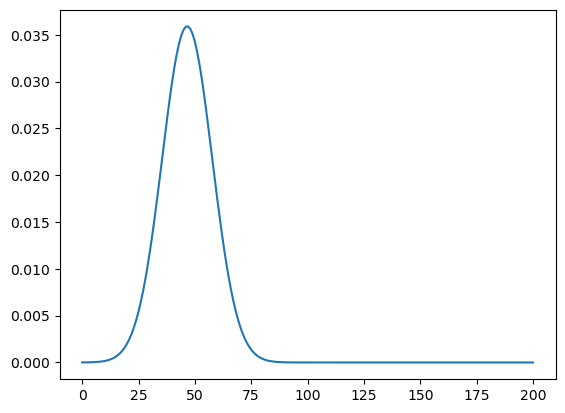

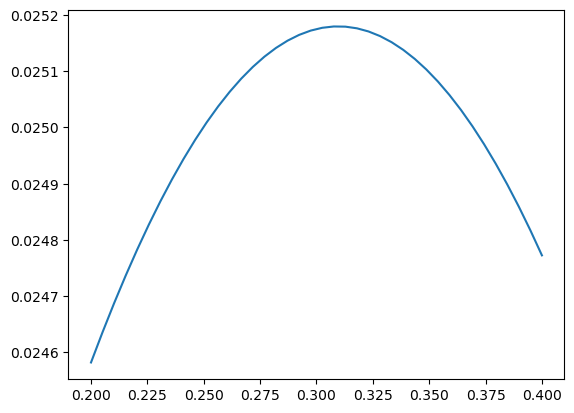

In [96]:
plt.plot(params.Om.squeeze(), Gaussian(params.Om, Planck18.Om0, 0.5).squeeze())
#plt.plot(np.exp(-(params.Om.squeeze() - 0.3)**2/(2*0.1**2))/np.sqrt(2*np.pi*0.1**2))
plt.show()

In [48]:
cos_bump = designer.EIG

In [14]:
np.save('n_tracers_w0wa_eigs_gaussian_0.005.npy', np.stack((designs.N_lrg, designer.EIG), axis=1))

In [5]:
designer.EIG

array([[4.46593658],
       [4.69691791],
       [4.84070305],
       [4.94053112],
       [5.01274279],
       [5.06529196],
       [5.10258775],
       [5.12723222],
       [5.14076148],
       [5.1439886 ],
       [5.13715568],
       [5.11997183],
       [5.09155469],
       [5.05024928],
       [4.99323417],
       [4.91567412],
       [4.80871045],
       [4.65372991],
       [4.39920181]])

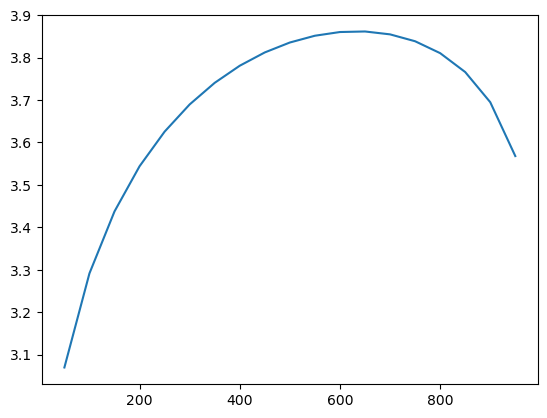

In [18]:
plt.plot(designs.N_lrg, designer.EIG)
#plt.plot(eig_02)
plt.show()

In [9]:
Om = np.load('n_tracers_w0wa_eigs.npy')

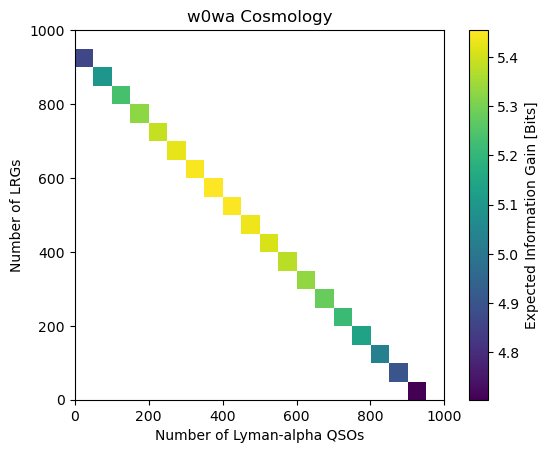

In [7]:
plt.figure()
#for i in range(18):
plt.imshow(designs.expand(designer.EIG), origin='lower', extent=[0, 1000, 0, 1000])
plt.xlabel('Number of Lyman-alpha QSOs')
plt.ylabel('Number of LRGs')
plt.colorbar(label='Expected Information Gain [Bits]')
plt.title(cosmo_type + " Cosmology")
plt.show()

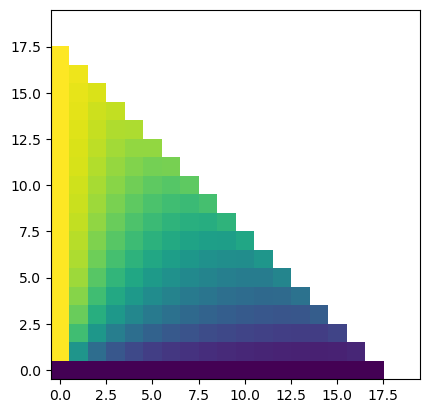

In [38]:
for i in range(20):
    plt.imshow(designs.expand(designer.EIG)[:,:,i], origin='lower')
plt.show()

In [82]:
#np.save('n_tracers_w0wa_eigs.npy', np.stack((designs.N_lrg, designer.EIG), axis=1))

In [ ]:
designer.EIG.shape

In [ ]:
plt.figure()
max_idx = np.unravel_index(np.argmax(designer.EIG), designer.EIG.shape)
#plt.scatter(designs.N_lrg[max_idx[0]] - 45, designs.N_lya[0][max_idx[1]] - 45, color='r', marker='x', label='max EIG')
plt.imshow(designs.expand(designer.EIG).T, origin='lower', extent=(10, 1000, 10, 1000))
# mark the maximum at pixel center
plt.xlabel('$N_{LRG}$')
plt.ylabel('$N_{Lya}$')
plt.colorbar(label='EIG [bits]')
plt.legend()
plt.show()

In [60]:
z_eff = torch.tensor([2.0, 2.5])

In [ ]:
z_eff.reshape(2*[1] + [-1]).shape

In [ ]:
desi_data = pd.read_csv('/home/ashandonay/bed/desi_data.csv')
n_tot = 1000
designs = Grid(N_lrg=np.arange(100, 1100, 100), N_lya=np.arange(100, 1100, 100), constraint = lambda N_lrg, N_lya: N_lrg + N_lya == n_tot)
params = Grid(Om=np.linspace(0.2, 0.4, 50), w0=np.linspace(-3, 1, 50), wa=np.linspace(-3, 2, 50))

redshift_1 = desi_data.loc[(desi_data['tracer'] == 'LRG2') & (desi_data['quantity'] == 'DH_over_rs'), "z"].values[0]
redshift_2 = desi_data.loc[(desi_data['tracer'] == 'Lya QSO') & (desi_data['quantity'] == 'DH_over_rs'), "z"].values[0]

DH_std_1 = desi_data.loc[(desi_data['tracer'] == 'LRG2') & (desi_data['quantity'] == 'DH_over_rs'), "std"].values[0]
DH_std_2 = desi_data.loc[(desi_data['tracer'] == 'Lya QSO') & (desi_data['quantity'] == 'DH_over_rs'), "std"].values[0]

include_D_M = False

if include_D_M:
    features = Grid(D_H_lrg=np.linspace(18, 22, 201), D_H_lya=np.linspace(7, 11, 201), D_M_lrg=np.linspace(15, 19, 21), D_M_lya=np.linspace(35, 45, 21))
    DM_std_1 = desi_data.loc[(desi_data['tracer'] == 'LRG2') & (desi_data['quantity'] == 'DM_over_rs'), "std"].values[0]
    DM_std_2 = desi_data.loc[(desi_data['tracer'] == 'Lya QSO') & (desi_data['quantity'] == 'DM_over_rs'), "std"].values[0]
    sigmas = np.array([DH_std_1, DH_std_2, DM_std_1, DM_std_2])
else:
    features = Grid(D_H_lrg=np.linspace(0.1, 40, 51), D_H_lya=np.linspace(0.1, 40, 51))
    sigmas = np.array([DH_std_1, DH_std_2])

z_eff = np.array([redshift_1, redshift_2])

plt.figure(figsize=(8,8))
cmap = plt.get_cmap('viridis')
N_lrgs = [100, 300, 500, 700, 900]
for i, n in enumerate(N_lrgs):

    true_n_vals = np.array([n, n_tot-n])

    cosmo = bed_cosmology(
        params,
        z_eff=z_eff,
        sigmas=sigmas,
        true_n_vals=true_n_vals,
        include_D_M=include_D_M
        )

    likelihood = cosmo.likelihood(params, features, designs)

    prior = np.ones(params.shape)
    params.normalize(prior);
    designer = ExperimentDesigner(params, features, designs, likelihood)
    designer.calculateEIG(prior)

    plt.plot(designer.EIG, label=f'$N_{{LRG}} = {n}$', color=cmap(i/len(N_lrgs)))
plt.ylabel('EIG [bits]')
plt.xlabel('Design index')
plt.legend()
plt.show()

In [34]:
train_args = {
    "tracers": ["LRG1", "LRG2", "LRG3 ELG1", "ELG2", "Lya QSO"],
    "design_scope": 0.05,
    "design_precision": 2,
    "device": device
}

desi_data = pd.read_csv('/home/ashandonay/bed/desi_data.csv')
sigma_D_H = []
sigma_D_M = []
z_eff = []
true_n_vals = []
for t in train_args["tracers"]:
    D_H_std = desi_data.loc[(desi_data['tracer'] == t) & (desi_data['quantity'] == 'DH_over_rs'), "std"].values[0]
    D_M_std = desi_data.loc[(desi_data['tracer'] == t) & (desi_data['quantity'] == 'DM_over_rs'), "std"].values[0]
    z = desi_data.loc[desi_data['tracer'] == t, "z"].values[0]
    sigma_D_H.append(D_H_std * 1.0)
    sigma_D_M.append(D_M_std * 1.0)
    z_eff.append(z)
    true_n_vals.append(desi_data.loc[desi_data['tracer'] == t, "num"].values[0])

sigma_D_H = torch.tensor(sigma_D_H, device=train_args["device"])
sigma_D_M = torch.tensor(sigma_D_M, device=train_args["device"])
z_eff = torch.tensor(z_eff, device=train_args["device"])
true_n_vals = torch.tensor(true_n_vals, device=train_args["device"])
true_n_ratios = true_n_vals/true_n_vals.sum()

base = 5.0
designs_dict = {}
for i in range(len(train_args["tracers"])):
    #designs_dict['N_' + train_args["tracers"][i].split()[0]] = np.arange(0.0, 0.3, 0.05)
    designs_dict['N_' + train_args["tracers"][i].split()[0]] = np.arange(
        np.round(true_n_ratios[i].cpu().numpy() - train_args["design_scope"], train_args["design_precision"]), 
        np.round(true_n_ratios[i].cpu().numpy() + train_args["design_scope"], train_args["design_precision"]), 
        np.power(base, -train_args["design_precision"])
        )
grid_designs = Grid(**designs_dict, constraint=lambda **kwargs: np.abs(sum(kwargs.values()) - 1.0) < np.power(base, -(train_args["design_precision"] + 1)))
del designs_dict
print("Grid designs shape:", grid_designs.shape)

designs = torch.tensor(getattr(grid_designs, grid_designs.names[0]).squeeze(), device=device).unsqueeze(1)
for n in grid_designs.names[1:]:
    designs = torch.cat((designs, torch.tensor(getattr(grid_designs, n).squeeze(), device=device).unsqueeze(1)), dim=1)

Grid designs shape: (45, 1, 1, 1, 1)


In [ ]:
plt.imshow(designs.expand(designer.EIG).T - diff_sig, origin='lower', extent=(10, 1000, 10, 1000))
plt.xlabel('$N_{LRG}$')
plt.ylabel('$N_{Lya}$')
plt.colorbar(label='EIG Difference [bits]')
plt.show()

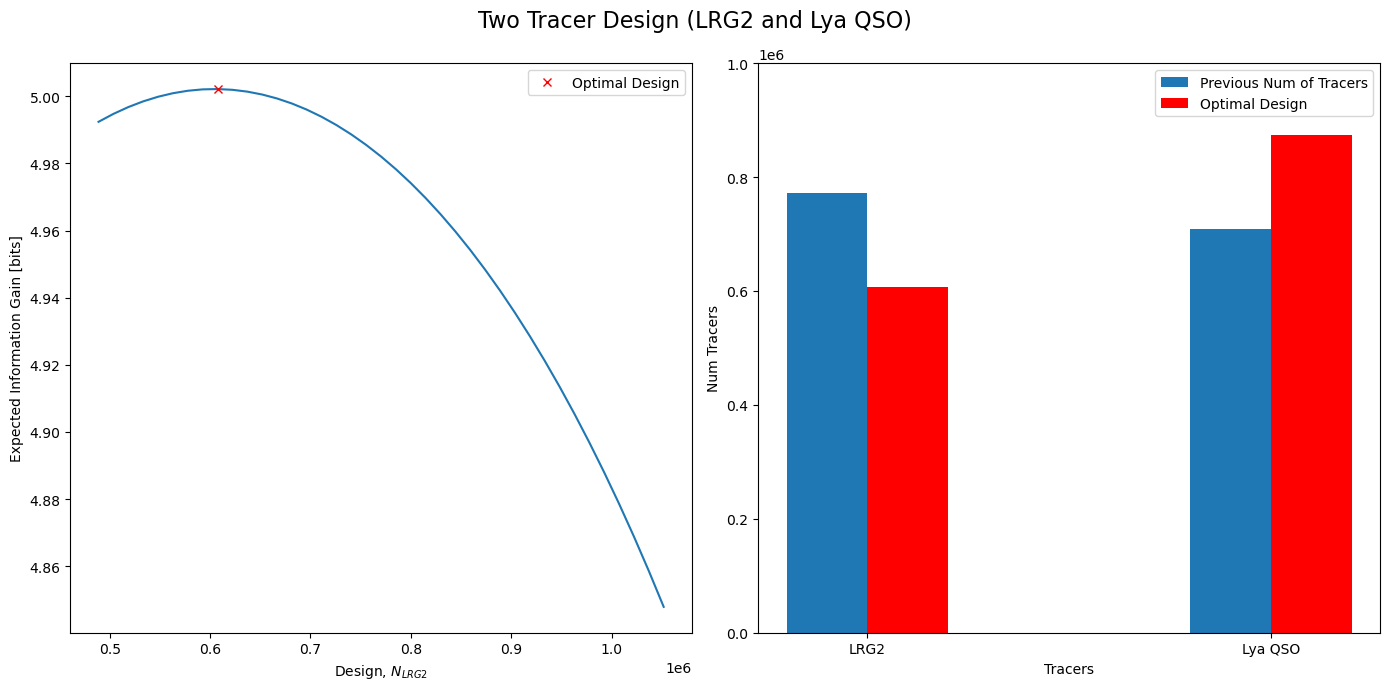

In [6]:
eigs = np.load('/home/ashandonay/bed/BED_examples/cosmology/mlruns/915317822116182339/d116061dafa54c6ca36b61a381f9316a/artifacts/brute_force_eigs.npy')
designs = np.load('/home/ashandonay/bed/BED_examples/cosmology/mlruns/915317822116182339/d116061dafa54c6ca36b61a381f9316a/artifacts/designs.npy')
tot = desi_data.loc[desi_data["tracer"] == "LRG2", "num"].iloc[0] + desi_data.loc[desi_data["tracer"] == "Lya QSO", "num"].iloc[0]
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].plot(tot*designs[0], eigs)
# place a marker at the maximum
ax[0].plot(tot*designs[0, np.where(eigs == eigs.max())][0], eigs.max(), 'rx', label="Optimal Design")
ax[0].set_xlabel("Design, $N_{LRG2}$")
ax[0].set_ylabel("Expected Information Gain [bits]")
ax[0].legend()

# Define the categories and values
categories = ['LRG2', 'Lya QSO']
values1 = [desi_data.loc[desi_data["tracer"] == "LRG2", "num"].iloc[0], desi_data.loc[desi_data["tracer"] == "Lya QSO", "num"].iloc[0]]  # Values for the first set of bars
values2 = [int(tot*designs[0, 8]), int(tot*designs[1, 8])]  # Values for the second set of bars

# Set the positions for the bars
x = np.arange(len(categories))  # the label locations
width = 0.2 # the width of the bars

bars1 = ax[1].bar(x - width/2, values1, width, label='Previous Num of Tracers')
bars2 = ax[1].bar(x + width/2, values2, width, label='Optimal Design', color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[1].set_xlabel('Tracers')
ax[1].set_ylabel('Num Tracers')
ax[1].set_xticks(x)
ax[1].set_xticklabels(categories)
ax[1].set_ylim(0, 1000000)
ax[1].legend()

# set super title
plt.suptitle("Two Tracer Design (LRG2 and Lya QSO)", fontsize=16)
plt.tight_layout()
plt.show()

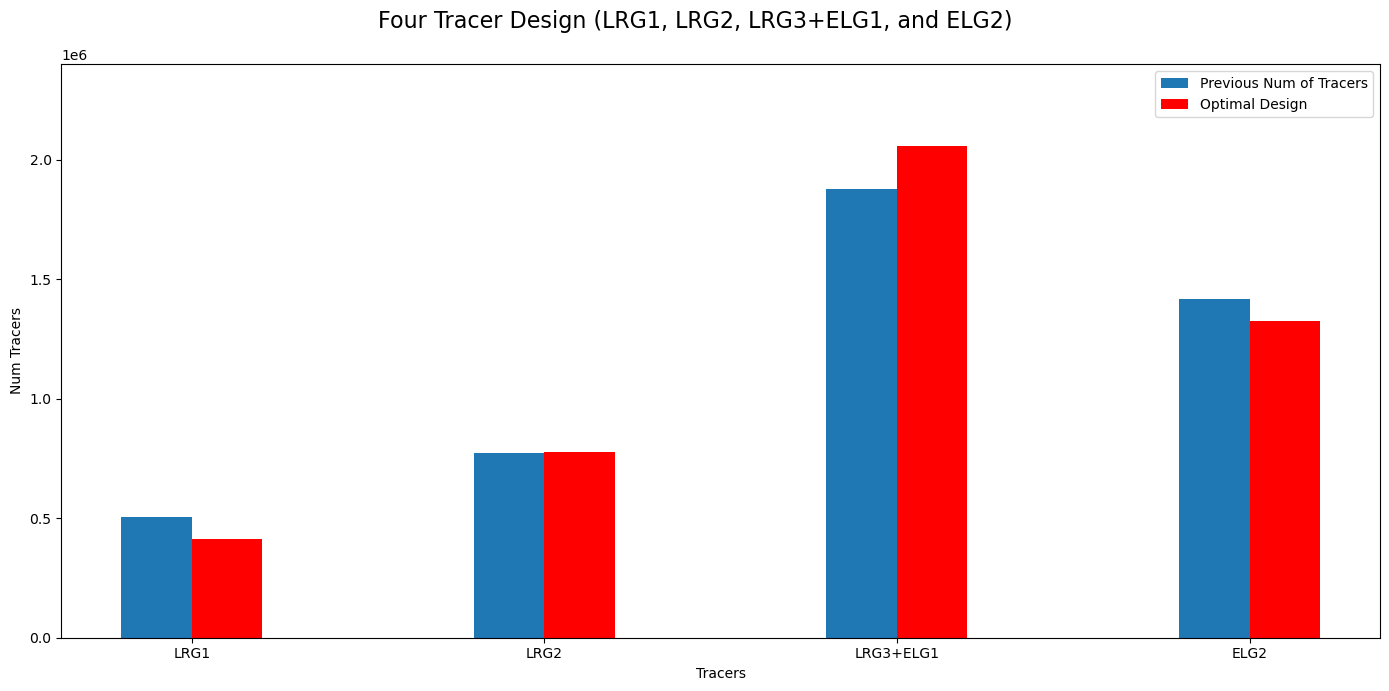

In [7]:
eigs = np.load('/home/ashandonay/bed/BED_examples/cosmology/mlruns/147584083322716898/e075af547c6149c2b15e05b0a2be461e/artifacts/eigs.npy')
designs = np.load('/home/ashandonay/bed/BED_examples/cosmology/mlruns/147584083322716898/e075af547c6149c2b15e05b0a2be461e/artifacts/design_eigs.npy')

optimal_design = designs[np.where(eigs == eigs.max())][0]
# same bar chart as above but with 4 categories
# Define the categories and values
categories = ['LRG1', 'LRG2', 'LRG3+ELG1', 'ELG2']
tot = desi_data.loc[desi_data["tracer"] == "LRG1", "num"].iloc[0] + desi_data.loc[desi_data["tracer"] == "LRG2", "num"].iloc[0] + desi_data.loc[desi_data["tracer"] == "LRG3 ELG1", "num"].iloc[0] + desi_data.loc[desi_data["tracer"] == "ELG2", "num"].iloc[0]
values1 = [desi_data.loc[desi_data["tracer"] == "LRG1", "num"].iloc[0], desi_data.loc[desi_data["tracer"] == "LRG2", "num"].iloc[0], desi_data.loc[desi_data["tracer"] == "LRG3 ELG1", "num"].iloc[0], desi_data.loc[desi_data["tracer"] == "ELG2", "num"].iloc[0]]  # Values for the first set of bars
values2 = tot*optimal_design  # Values for the second set of bars

# Set the positions for the bars
x = np.arange(len(categories))  # the label locations
width = 0.2 # the width of the bars

# Create the bar chart
fig, ax = plt.subplots(figsize=(14, 7))
bars1 = ax.bar(x - width/2, values1, width, label='Previous Num of Tracers')
bars2 = ax.bar(x + width/2, values2, width, label='Optimal Design', color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Tracers')
ax.set_ylabel('Num Tracers')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylim(0, 2400000)
ax.legend()

# set super title
plt.suptitle("Four Tracer Design (LRG1, LRG2, LRG3+ELG1, and ELG2)", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()
